# Container Dwell Time Analysis
## December 2024 Data Analysis

This notebook showcases the key findings from our container dwell time analysis, focusing on:
1. Distribution modeling and comparison
2. Cycle analysis and patterns
3. Container type comparisons (Dry vs Reefer)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]

In [6]:
# Read and prepare data
df = pd.read_csv('merged_results_final_december.csv')

# Convert dates to datetime
df['DischargedDate'] = pd.to_datetime(df['DischargedDate'], errors='coerce', utc=True).dt.tz_localize(None)
df['GateOutDate'] = pd.to_datetime(df['GateOutDate'], errors='coerce', utc=True).dt.tz_localize(None)

# Calculate dwell times
both_dates = df[df['DischargedDate'].notna() & df['GateOutDate'].notna()].copy()
both_dates['dwell_time_days'] = (both_dates['GateOutDate'] - both_dates['DischargedDate']).dt.total_seconds() / (24*60*60)

# Categorize containers
def categorize_container(iso_code):
    if pd.isna(iso_code):
        return 'Unknown'
    iso_code = str(iso_code).upper()
    return 'Reefer' if 'R' in iso_code else 'Dry'

both_dates['container_category'] = both_dates['IsoCode'].apply(categorize_container)

# Print basic statistics
print(f"Total containers: {len(df):,}")
print(f"Containers with complete dwell times: {len(both_dates):,}")
print(f"\nAverage dwell time: {both_dates['dwell_time_days'].mean():.1f} days")
print(f"Median dwell time: {both_dates['dwell_time_days'].median():.1f} days")
print(f"95th percentile dwell time: {both_dates['dwell_time_days'].quantile(0.95):.1f} days")

# Container type distribution
type_dist = both_dates['container_category'].value_counts()
print("\nContainer Type Distribution:")
print(type_dist)
print("\nPercentages:")
print(type_dist / len(both_dates) * 100)

Total containers: 51,099
Containers with complete dwell times: 42,173

Average dwell time: 3.1 days
Median dwell time: 2.9 days
95th percentile dwell time: 7.1 days

Container Type Distribution:
container_category
Dry       39916
Reefer     2257
Name: count, dtype: int64

Percentages:
container_category
Dry       94.648235
Reefer     5.351765
Name: count, dtype: float64


## Distribution Model Comparison

We compare different statistical models to understand the dwell time distribution:
1. Gaussian Kernel Density Estimation (KDE)
2. Circular KDE (accounting for weekly patterns)
3. Normal Distribution
4. Fourier Series

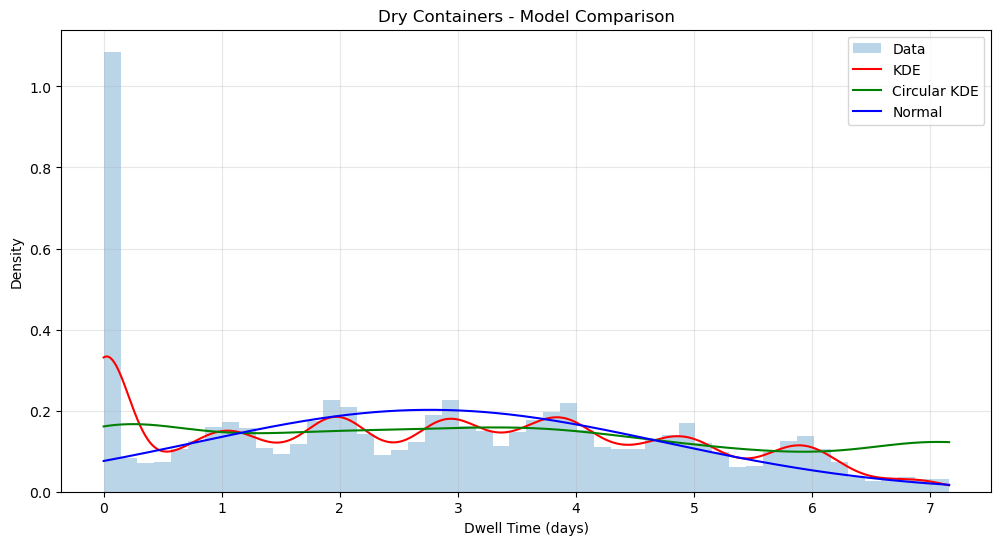

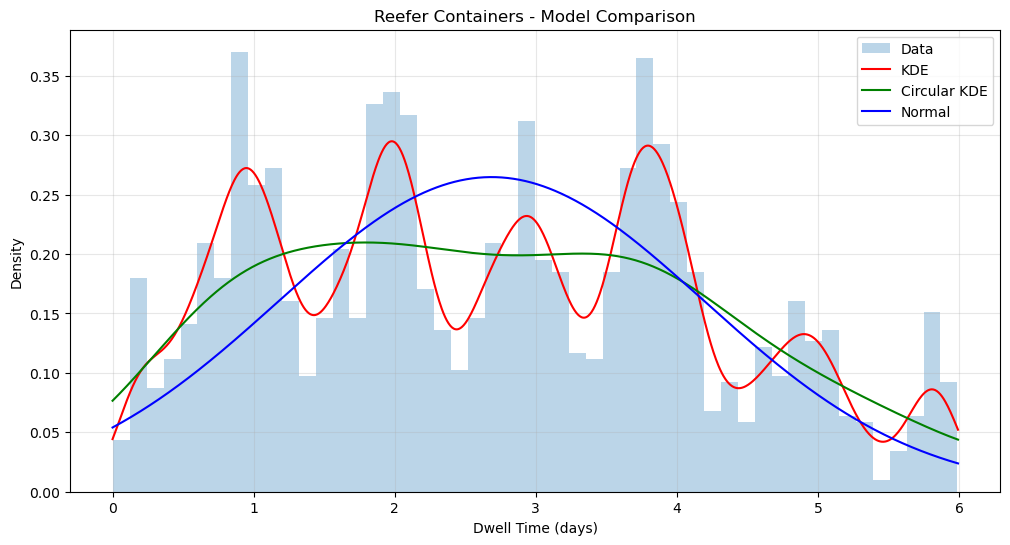

In [3]:
def circular_kde(data, x, bw=0.1, period=7):
    wrapped_data = np.concatenate([data - period, data, data + period])
    kde = gaussian_kde(wrapped_data, bw_method=bw)
    density = kde(x)
    density_left = kde(x - period)
    density_right = kde(x + period)
    return density + density_left + density_right

def fourier_series(x, *params):
    n_terms = (len(params) - 1) // 2
    result = params[0] / 2
    for i in range(n_terms):
        n = i + 1
        a = params[2*i + 1]
        b = params[2*i + 2]
        result += a * np.cos(n * x) + b * np.sin(n * x)
    return result

def plot_model_comparison(data, category):
    data_filtered = data[data <= np.percentile(data, 95)]
    X_train, X_test = train_test_split(data_filtered, test_size=0.2, random_state=42)
    
    hist_train, bin_edges = np.histogram(X_train, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    kde = gaussian_kde(X_train, bw_method=0.1)
    mu, std = norm.fit(X_train)
    
    x_plot = np.linspace(0, np.max(data_filtered), 1000)
    x_plot_scaled = x_plot / np.max(data_filtered) * 2 * np.pi
    
    plt.figure(figsize=(12, 6))
    plt.hist(X_train, bins=50, density=True, alpha=0.3, label='Data')
    plt.plot(x_plot, kde(x_plot), 'r-', label='KDE')
    plt.plot(x_plot, circular_kde(X_train, x_plot), 'g-', label='Circular KDE')
    plt.plot(x_plot, norm.pdf(x_plot, mu, std), 'b-', label='Normal')
    
    plt.title(f'{category} Containers - Model Comparison')
    plt.xlabel('Dwell Time (days)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot for each container type
for category in ['Dry', 'Reefer']:
    data = both_dates[both_dates['container_category'] == category]['dwell_time_days'].values
    plot_model_comparison(data, category)

## Cycle Analysis

Here we analyze the cyclical patterns in container movements using Gaussian Mixture Models (GMM) and temporal analysis.


Dry Containers Analysis:


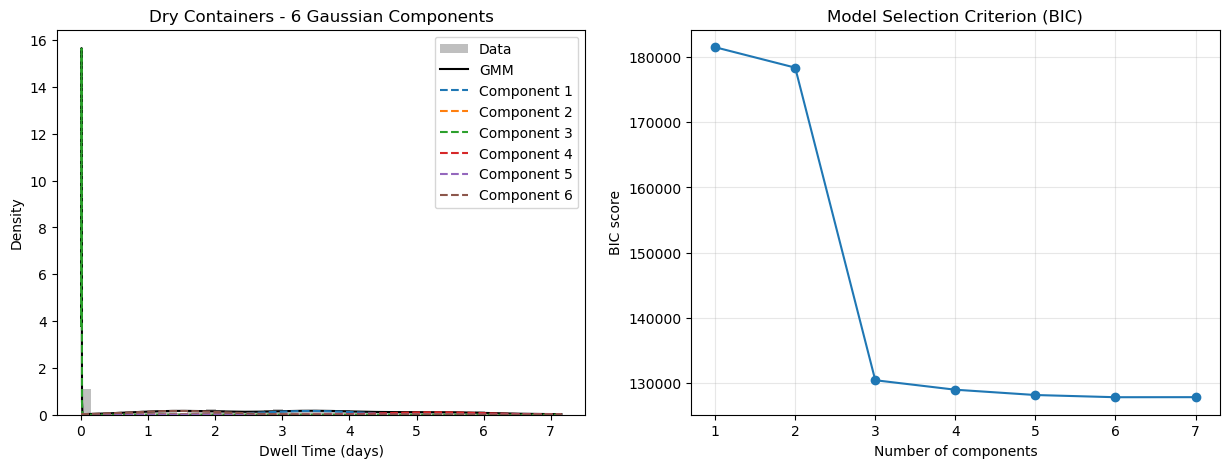


Reefer Containers Analysis:


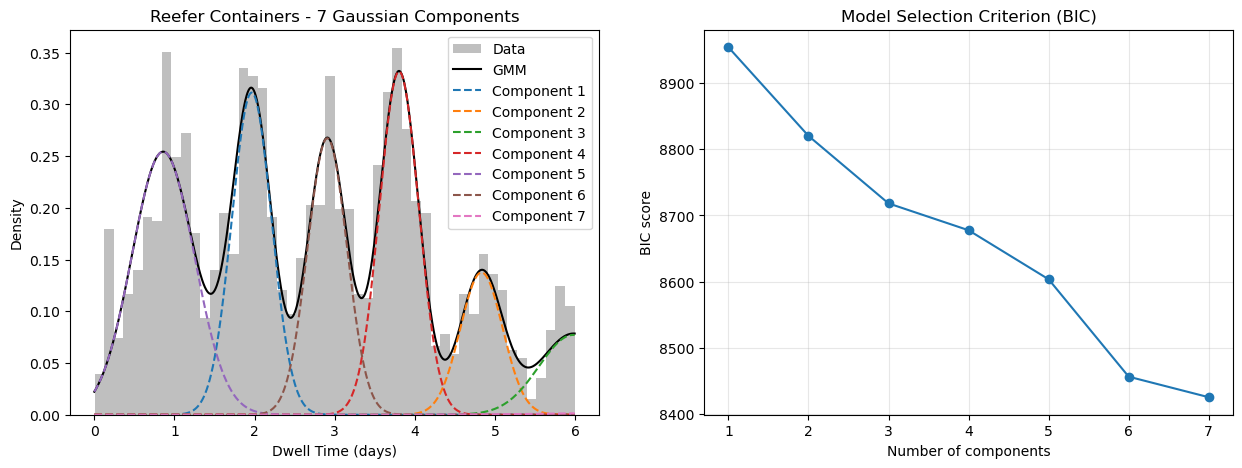

In [4]:
def analyze_cycles(data, category):
    # GMM Analysis
    X = data.reshape(-1, 1)
    n_components_range = range(1, 8)
    bic = []
    lowest_bic = np.inf
    best_gmm = None
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    
    optimal_components = n_components_range[np.argmin(bic)]
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: GMM components
    plt.subplot(1, 2, 1)
    x_plot = np.linspace(0, np.percentile(data, 95), 1000).reshape(-1, 1)
    plt.hist(data[data <= np.percentile(data, 95)], bins=50, density=True, alpha=0.5, color='gray', label='Data')
    
    logprob = best_gmm.score_samples(x_plot)
    responsibilities = best_gmm.predict_proba(x_plot)
    pdf = np.exp(logprob)
    plt.plot(x_plot, pdf, 'k-', label='GMM')
    
    for i in range(optimal_components):
        pdf_component = responsibilities[:, i] * pdf
        plt.plot(x_plot, pdf_component, '--', label=f'Component {i+1}')
    
    plt.title(f'{category} Containers - {optimal_components} Gaussian Components')
    plt.xlabel('Dwell Time (days)')
    plt.ylabel('Density')
    plt.legend()
    
    # Plot 2: BIC scores
    plt.subplot(1, 2, 2)
    plt.plot(n_components_range, bic, 'o-')
    plt.title('Model Selection Criterion (BIC)')
    plt.xlabel('Number of components')
    plt.ylabel('BIC score')
    plt.grid(True, alpha=0.3)
    plt.show()

# Analyze each container type
for category in ['Dry', 'Reefer']:
    data = both_dates[both_dates['container_category'] == category]['dwell_time_days'].values
    print(f"\n{category} Containers Analysis:")
    analyze_cycles(data, category)

## Temporal Patterns

Analysis of daily and hourly patterns in container movements.

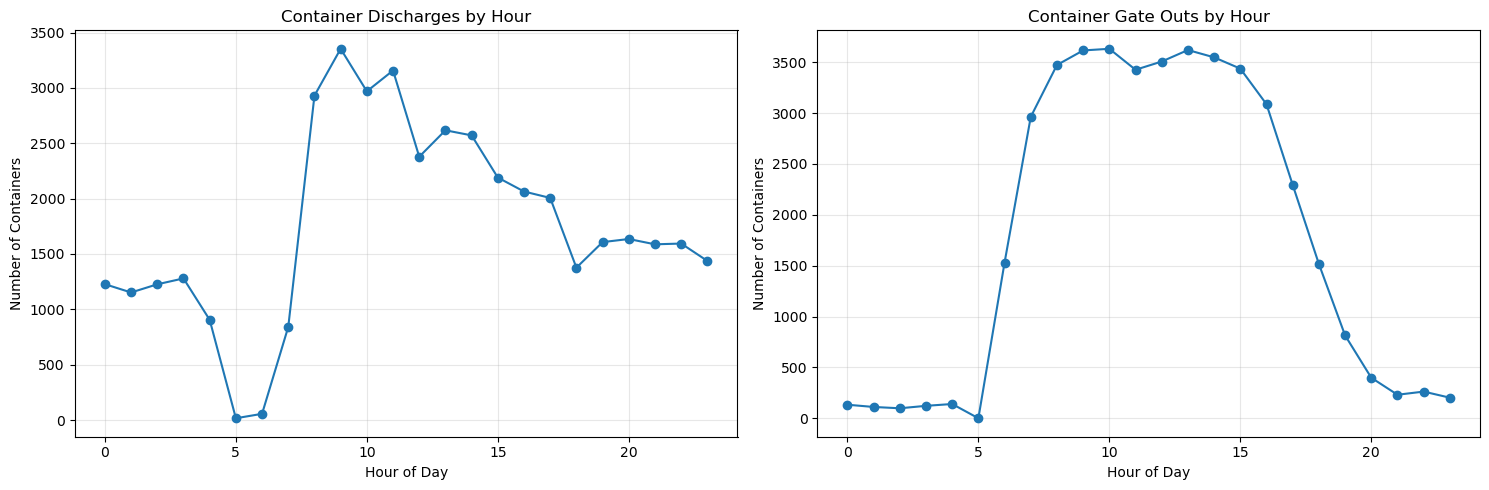

Peak Hours:
Discharge: Hour 9 (3,353 containers)
Gate Out: Hour 10 (3,632 containers)


In [5]:
# Add temporal features
both_dates['discharge_hour'] = both_dates['DischargedDate'].dt.hour
both_dates['discharge_dow'] = both_dates['DischargedDate'].dt.dayofweek
both_dates['gateout_hour'] = both_dates['GateOutDate'].dt.hour
both_dates['gateout_dow'] = both_dates['GateOutDate'].dt.dayofweek

# Plot hourly patterns
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
hourly_discharge = both_dates.groupby('discharge_hour')['ContainerId'].count()
plt.plot(hourly_discharge.index, hourly_discharge.values, 'o-')
plt.title('Container Discharges by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Containers')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
hourly_gateout = both_dates.groupby('gateout_hour')['ContainerId'].count()
plt.plot(hourly_gateout.index, hourly_gateout.values, 'o-')
plt.title('Container Gate Outs by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Containers')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print peak hours
print("Peak Hours:")
print(f"Discharge: Hour {hourly_discharge.idxmax()} ({hourly_discharge.max():,.0f} containers)")
print(f"Gate Out: Hour {hourly_gateout.idxmax()} ({hourly_gateout.max():,.0f} containers)")